In [ ]:
import os
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report


import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [ ]:
wandb.init(
    project="mrl-eye-cnn",
    name="cnn_v3", # v3
    config={
        "img_size": 64,
        "batch_size": 32,
        "epochs": 30,
        "optimizer": "AdamW",
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "loss": "binary_crossentropy"
    }
)

config = wandb.config


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: omarhariri (omarhariri-syrian-private-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
DATA_DIR = "/content/MRL/data"
IMG_SIZE = (config.img_size, config.img_size)
BATCH_SIZE = config.batch_size

In [ ]:

for split in ["train", "val", "test"]:
    split_path = os.path.join(DATA_DIR, split)
    print(f"\n{split.upper()}:")

    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            n = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith((".jpg", ".png", ".jpeg"))
            ])
            total += n
            print(f"  {cls}: {n}")

    print(f"  Total: {total}")



TRAIN:
  awake: 25770
  sleepy: 25167
  Total: 50937

VAL:
  awake: 8591
  sleepy: 8389
  Total: 16980

TEST:
  awake: 8591
  sleepy: 8390
  Total: 16981


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    "/content/MRL/data/train",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    "/content/MRL/data/val",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    "/content/MRL/data/test",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 50937 images belonging to 2 classes.
Found 16980 images belonging to 2 classes.
Found 16981 images belonging to 2 classes.


In [ ]:
print("Class indices:", train_gen.class_indices)

Class indices: {'awake': 0, 'sleepy': 1}


In [ ]:
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),

    # Block 1
    layers.Conv2D(32, (3,3), activation="relu", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Classifier
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=l2(1e-4)),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid")
])

optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,553 (1.34 MB)

 Trainable params: 351,233 (1.34 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

checkpoint = WandbModelCheckpoint(
    filepath="/content/checkpoints/best_model.keras",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks = [
    early_stop,
    checkpoint,
    reduce_lr,
    WandbMetricsLogger()
]


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=config.epochs,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 57s 27ms/step - accuracy: 0.8997 - loss: 0.3281 - val_accuracy: 0.9475 - val_loss: 0.1766 - learning_rate: 0.0010
Epoch 2/30
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9635 - loss: 0.1489 - val_accuracy: 0.9764 - val_loss: 0.1177 - learning_rate: 0.0010
Epoch 3/30
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.9724 - loss: 0.1281 - val_accuracy: 0.9526 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 4/30
1590/1592 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9752 - loss: 0.1238
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9752 - loss: 0.1238 - val_accuracy: 0.9749 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 5/30
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.9825 - loss: 0.1012 - val_accuracy: 0.9866 - val_loss: 0.0829 - learning_rate: 3.0000e-04
Epoch 6/30
1592/1592 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - accu

In [12]:
# Evaluate overall accuracy/loss
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")


Val Accuracy: 0.9896, Val Loss: 0.0569


In [13]:
test_loss, test_acc = model.evaluate(test_gen)
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc
})

531/531 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.9916 - loss: 0.0555


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    "../data/MRL/test",
    target_size=(64,64),
    color_mode="grayscale",
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

Found 16981 images belonging to 2 classes.


In [3]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

In [14]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_gen, verbose=1)

# Convert probabilities → class indices (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # flatten

# True labels
y_true = test_gen.classes

print("Predictions done.")


531/531 ━━━━━━━━━━━━━━━━━━━━ 55s 103ms/step
Predictions done.


In [ ]:
from sklearn.metrics import classification_report
class_names = list(test_gen.class_indices.keys())
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
)

print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

       awake     0.9914    0.9916    0.9915      8591
      sleepy     0.9914    0.9912    0.9913      8390

    accuracy                         0.9914     16981
   macro avg     0.9914    0.9914    0.9914     16981
weighted avg     0.9914    0.9914    0.9914     16981



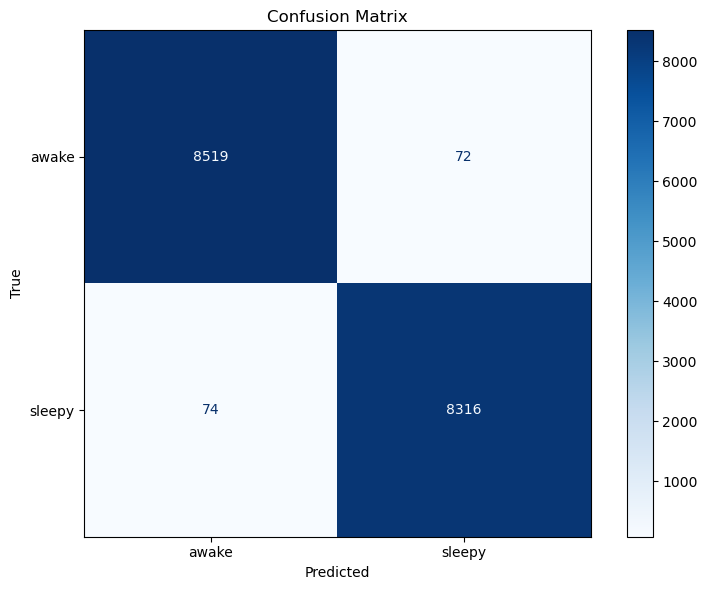

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(cm, display_labels=['awake','sleepy'])
cmd.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# Finish the run
wandb.finish()